In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# Data Exploring

In [12]:
# From https://www.kaggle.com/datasets/crawford/emnist download the datasets called emnist-balanced-train.csv, emnist-balanced-test.csv, emnist-balanced-mapping.txt and unzip
# Pass the path to the datasets
trainData = pd.read_csv('/Users/pc/PythonDevEnv/dsenv/PFE/dataset/emnist-balanced-train.csv', header = None)

# Mapper: text file that contains the mapping between the letters and digits classes, with their ASCII code
mapper = pd.read_csv('/Users/pc/PythonDevEnv/dsenv/PFE/dataset/emnist-balanced-mapping.txt', delimiter = ' ', header = None)

In [39]:
# Check the shape of the dataset
print('Data shape:', trainData.shape)

# First couple rows
print(trainData.head())

# Get basic info about the dataset
print(trainData.info())

Data shape: (112800, 785)
   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0   45    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1   36    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2   43    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3   15    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    4    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112800 entries, 0 to 112799
Columns: 785 entries, 0 to 784
dtypes: int64(785)
memory usage: 675.6 MB
None


In [40]:
# Columns
print(trainData.columns)

# Check data distribution
trainData.iloc[:,0].value_counts()

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            775, 776, 777, 778, 779, 780, 781, 782, 783, 784],
           dtype='int64', length=785)


45    2400
7     2400
22    2400
34    2400
9     2400
30    2400
38    2400
39    2400
37    2400
31    2400
16    2400
2     2400
28    2400
8     2400
10    2400
6     2400
27    2400
33    2400
11    2400
18    2400
41    2400
0     2400
23    2400
35    2400
36    2400
13    2400
43    2400
15    2400
4     2400
42    2400
26    2400
32    2400
20    2400
1     2400
46    2400
24    2400
25    2400
12    2400
5     2400
17    2400
3     2400
40    2400
14    2400
44    2400
19    2400
29    2400
21    2400
Name: 0, dtype: int64

In [13]:
# Get a look over our labels
labels = mapper.iloc[:, 1]
labelsDict = {}

for index, label in enumerate(labels):
    labelsDict[index] = chr(label)
    
print(labelsDict)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'd', 39: 'e', 40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q', 45: 'r', 46: 't'}


# Data Preprocessing

In [50]:
# Check for missing values
print('Total missing values:', trainData.isna().sum().sum())

# Check if there're any values out of range [0, 255]
print('min:', trainData.describe().loc['min'].min(), 'max:', trainData.describe().loc['max'].max())

# Check for duplicates
print('Total duplicates samples:', trainData.duplicated().sum())

# Basic statistics on training data
print(trainData.describe())

Total missing values: 0
min: 0.0 max: 255.0
Total duplicates samples: 2
                0         1         2         3         4              5    \
count  112800.00000  112800.0  112800.0  112800.0  112800.0  112800.000000   
mean       23.00000       0.0       0.0       0.0       0.0       0.001365   
std        13.56472       0.0       0.0       0.0       0.0       0.235046   
min         0.00000       0.0       0.0       0.0       0.0       0.000000   
25%        11.00000       0.0       0.0       0.0       0.0       0.000000   
50%        23.00000       0.0       0.0       0.0       0.0       0.000000   
75%        35.00000       0.0       0.0       0.0       0.0       0.000000   
max        46.00000       0.0       0.0       0.0       0.0      63.000000   

                 6              7              8              9    ...  \
count  112800.000000  112800.000000  112800.000000  112800.000000  ...   
mean        0.011560       0.020700       0.017438       0.018475  ...   
std

In [14]:
# Train features
X = trainData.iloc[:, 1:].values

# Train labels
y = trainData.iloc[:, 0].values

print('y shape:', y.shape, 'X shape:', X.shape)

y shape: (112800,) X shape: (112800, 784)


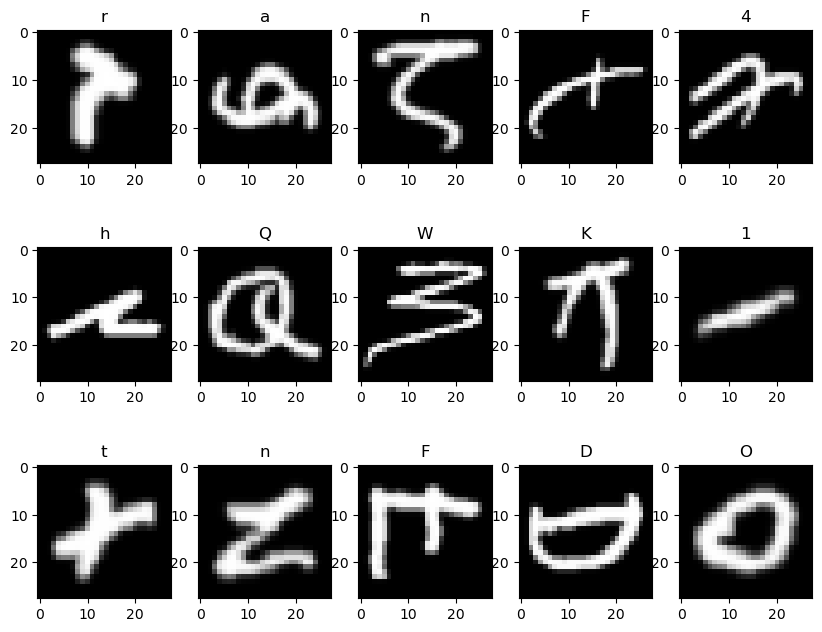

In [6]:
# Let's see what type of images we're working with

fig, axes = plt.subplots(3, 5, figsize = (10, 8))

for index, ax in enumerate(axes.flat):
    ax.imshow(X[index].reshape([28, 28]), cmap = 'gray')
    ax.set_title(chr(labels[y[index]]))

Label entry #39: (83, 'S')


Text(0.5, 1.0, 'S')

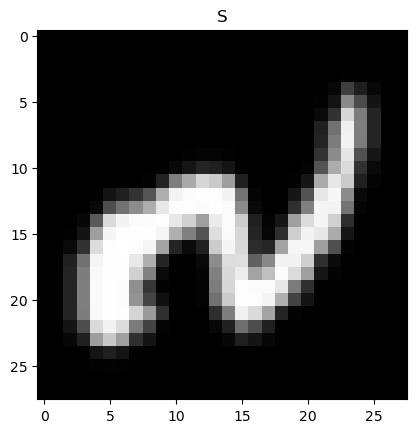

In [7]:
# Visualize a randomly chosen sample data (#39)
image39 = X[39].reshape(28, 28)

# Corresponding ASCII code
label39 = labels[y[39]]

print(f'Label entry #39: {label39, chr(label39)}')

plt.imshow(image39, cmap = 'gray')
plt.title(chr(label39))

# !!!! yeah... the output definitely does NOT look like an 'S' !!!!

In [15]:
height = 28
width = 28

# Function to reshape (28*28), flip (left to right) and rotate (90d) images, since all the data is in the same orientation
def rotate(image):
    # Reshape image to 28*28, just for visualization purposes
    image = image.reshape(height, width)
    
    # Flip and rotate
    image = np.fliplr(image)
    image = np.rot90(image)
    
    return image

Label entry #39: (83, 'S')


Text(0.5, 1.0, 'S')

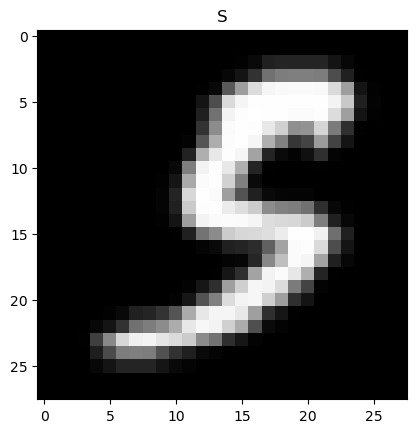

In [24]:
# Trying again to plot the CORRECT SHAPED 'S'
print(f'Label entry #39: {label39, chr(label39)}')
plt.imshow(rotate(image39), cmap = 'gray')
plt.title(chr(label39))

# !!! Now that's an 'S' !!!!

In [16]:
# Flip and rotate all image
X = np.apply_along_axis(rotate, 1, X)
print("X:", X.shape)

X: (112800, 28, 28)


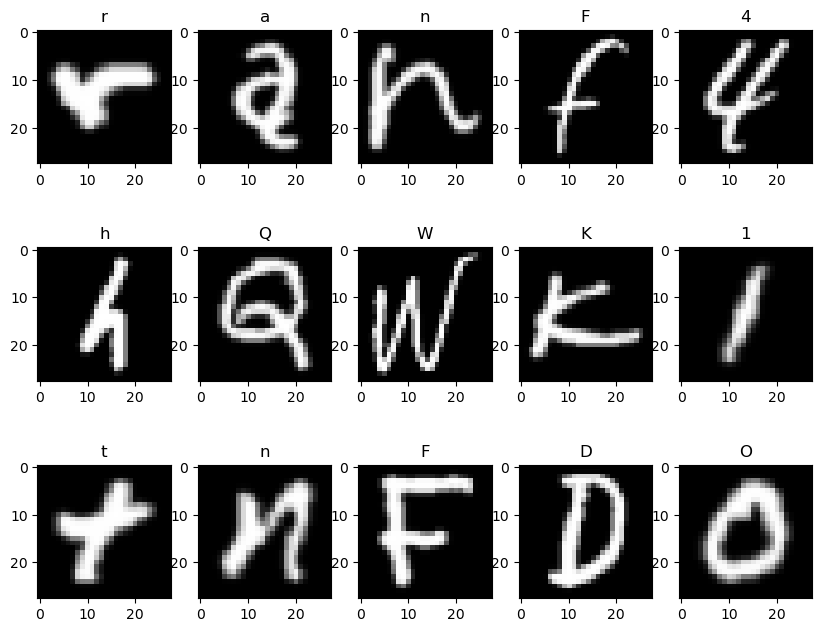

In [26]:
# Plot the labels again
fig2, axes2 = plt.subplots(3, 5, figsize = (10, 8))

for index, ax in enumerate(axes2.flat):
    ax.imshow(X[index], cmap = 'gray')
    ax.set_title(chr(labels[y[index]]))

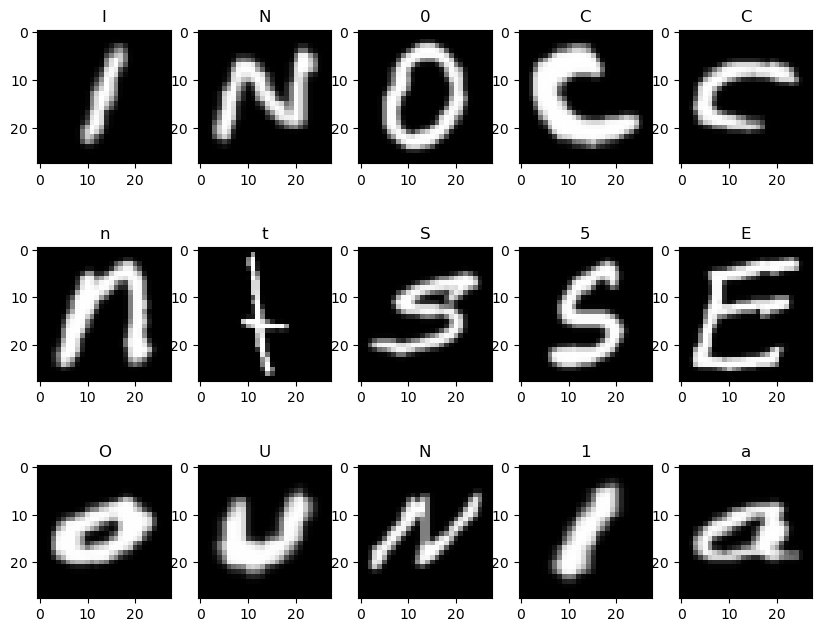

In [34]:
# Plot random samples
samples = np.random.choice(range(X.shape[0]), size = 15)

plt.figure(figsize = (10, 8))

for i, j in enumerate(samples):
    plt.subplot(3, 5, i + 1)
    plt.imshow(X[j], cmap = 'gray')
    plt.title(chr(labels[y[j]]))

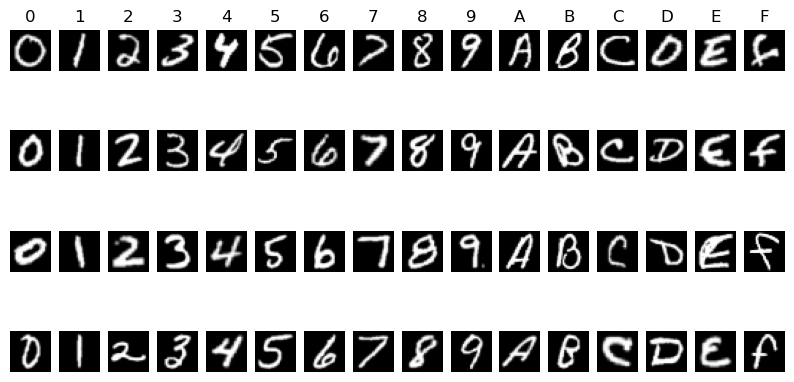

In [33]:
# Plot different variants of the same digit or letter
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']
rows = 4
plt.figure(figsize = (10, 5))

for index, label in enumerate(classes):
    indices = np.nonzero([i == index for i in y])
    indices = np.random.choice(indices[0], rows)
    for i , idx in enumerate(indices):
        plt_idx = i * len(classes) + index + 1
        plt.subplot(rows, len(classes), plt_idx)
        plt.imshow(X[idx].reshape(28, 28), cmap = 'gray')
        plt.axis("off")
        if i == 0:
            plt.title(chr(labels[y[idx]]))

plt.show()

In [17]:
# Reshape data to its original shape
X = X.reshape(-1, 784)

In [18]:
# Column-Normalizing
# Since the data is in the range [0, 255], we can normalize it by dividing each pixel by 255
X = X / 255

# Model Creation

In [19]:
# Split data into training and testing subsets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [10]:
print('X_train shape:', X_train.shape, 'y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape, 'y_test shape:', y_test.shape)

X_train shape: (90240, 784) y_train shape: (90240,)
X_test shape: (22560, 784) y_test shape: (22560,)


### KNN

In [10]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

# Finding the optimal number of neighbors
def findOptimalK(train_X, test_X, train_y, test_y):
    optimalK = 0
    highestScore = 0
    for k in range(1, 12):
        knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(train_X, train_y)
        score = knn.score(test_X, test_y)
        if score > highestScore:
            highestScore = score
            optimalK = k
    return optimalK

In [11]:
k = findOptimalK(X_train, X_test, y_train, y_test)

In [12]:
# Model creation
knnModel = KNeighborsClassifier(n_neighbors = k)

# Training
knnModel.fit(X_train, y_train)

# Saving the model
joblib.dump(knnModel, '/Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts/knnModel2.joblib')

['/Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts/knnModel2.joblib']

In [13]:
# Load saved model
knnModel_loaded = joblib.load('/Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts/knnModel2.joblib')

# Predictions
knnPredictions = knnModel_loaded.predict(X_test)

# Accuracy Score
print('KNN Accuracy Score:', accuracy_score(y_test, knnPredictions))

# Classification Report
print('KNN Classification Report:\n', classification_report(y_test, knnPredictions))

KNN Accuracy Score: 0.7777482269503546
KNN Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.67      0.54       457
           1       0.40      0.71      0.51       472
           2       0.85      0.81      0.83       479
           3       0.84      0.93      0.89       515
           4       0.77      0.85      0.81       460
           5       0.81      0.75      0.78       473
           6       0.81      0.90      0.85       484
           7       0.84      0.96      0.90       447
           8       0.84      0.83      0.84       496
           9       0.54      0.76      0.63       480
          10       0.83      0.84      0.83       494
          11       0.91      0.70      0.79       465
          12       0.78      0.92      0.85       469
          13       0.89      0.76      0.82       500
          14       0.93      0.86      0.89       465
          15       0.59      0.55      0.57       467
          16  

In [14]:
# KNN cross-validation
knnCVScore = cross_val_score(knnModel_loaded, X_train, y_train, cv = 5, scoring = 'accuracy').mean()

print('KNN cross-validation score:', knnCVScore)

KNN cross-validation score: 0.7705673758865248


In [71]:
joblib.dump(knnCVScore, '/Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts/knnCVScore.joblib')

['/Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts/knnCVScore.joblib']

In [16]:
# KNN Regularization
knnParams = {'weights': ['uniform', 'distance'],
              'metric' : ['euclidean', 'minkowski', 'manhattan'],
             }

gridKnn = GridSearchCV(knnModel, knnParams, cv = 5, scoring = 'accuracy')

In [17]:
gridKnn.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'minkowski', 'manhattan'],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [18]:
joblib.dump(gridKnn, '/Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts/gridKnn.joblib')

['/Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts/gridKnn.joblib']

In [19]:
print('Best score:', gridKnn.best_score_)
print('Best parameters:', gridKnn.best_params_)
print('Best estimator:', gridKnn.best_estimator_)

Best score: 0.7762854609929077
Best parameters: {'metric': 'euclidean', 'weights': 'distance'}
Best estimator: KNeighborsClassifier(metric='euclidean', weights='distance')


In [20]:
# Regularized model
regKnn = KNeighborsClassifier(metric = 'euclidean', n_neighbors = k, weights = 'distance')

regKnn.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', weights='distance')

In [ ]:
# Predictions
regKnnPredictions = regKnn.predict(X_test)

In [62]:
# Accuracy after regularization
print('Regularized KNN accuracy score:', accuracy_score(y_test, regKnnPredictions))

Regularized KNN accuracy score: 0.7832890070921986


In [20]:
# Function to plot random predicted samples alongside the actual values
def plotRandomPredictions(predictions, test_X, test_y, n_samples = 5):
    predSamples = np.random.choice(len(predictions), size = n_samples)

    for j in predSamples:
        predicted = predictions[j]
        actual = test_y[j]
        
        image = test_X[j]
        plt.subplot(3, 5, 2)
        plt.imshow(image.reshape(28, 28), cmap = 'gray')
        plt.axis(('off'))
        plt.show()
        
        print("Predicted value:", chr(labels[predicted]), "Actual value:", chr(labels[actual]), '' if predicted == actual else 'Wrong')

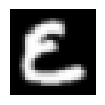

Predicted value: e Actual value: E Wrong


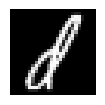

Predicted value: d Actual value: d 


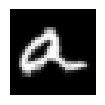

Predicted value: a Actual value: a 


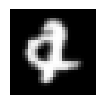

Predicted value: O Actual value: a Wrong


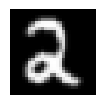

Predicted value: 2 Actual value: 2 


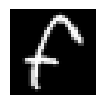

Predicted value: F Actual value: F 


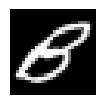

Predicted value: e Actual value: B Wrong


In [61]:
# Plot predictions
plotRandomPredictions(regKnnPredictions, X_test, y_test, 7)

### SVM

In [63]:
# SVM
from sklearn.svm import SVC

# Model creation
svmModel = SVC()

# Training
svmModel.fit(X_train, y_train)

# Saving the model
joblib.dump(svmModel, '/Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts/svmModel2.joblib')

['/Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts/svmModel2.joblib']

In [21]:
# Load saved model
svmModel_loaded = joblib.load('/Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts/svmModel2.joblib')

In [67]:
# Predictions
svmPredictions = svmModel_loaded.predict(X_test)

# Accuracy Score
print('SVM Accuracy Score:', accuracy_score(y_test, svmPredictions))

# Classification Report
print('SVM Classification Report:\n', classification_report(y_test, svmPredictions))

SVM Accuracy Score: 0.8409574468085106
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.68      0.65       457
           1       0.52      0.77      0.62       472
           2       0.85      0.84      0.84       479
           3       0.94      0.91      0.92       515
           4       0.85      0.89      0.87       460
           5       0.87      0.84      0.85       473
           6       0.89      0.88      0.89       484
           7       0.92      0.96      0.94       447
           8       0.85      0.84      0.84       496
           9       0.66      0.87      0.75       480
          10       0.84      0.92      0.88       494
          11       0.89      0.90      0.90       465
          12       0.91      0.92      0.92       469
          13       0.89      0.89      0.89       500
          14       0.94      0.92      0.93       465
          15       0.68      0.53      0.60       467
          16  

In [68]:
joblib.dump(svmPredictions, '/Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts/svmPredictions2.joblib')

['/Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts/svmPredictions2.joblib']

In [69]:
# SVM cross-validation
svmCVScore = cross_val_score(svmModel_loaded, X_train, y_train, cv = 5, scoring = 'accuracy').mean()

print('SVM cross-validation score:', svmCVScore)

SVM cross-validation score: 0.8338763297872342


In [70]:
# Save cross-validation score
joblib.dump(svmCVScore, '/Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts/svmCVScore.joblib')

['/Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts/svmCVScore.joblib']

In [ ]:
# SVM regularization
svmParams = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

gridSvm = GridSearchCV(svmModel_loaded, svmParams, cv = 5, scoring = 'accuracy')

In [ ]:
# Training the model
gridSvm.fit(X_train, y_train)

# Saving the model
joblib.dump(gridSvm, '/Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts/gridSvm.joblib')

In [ ]:
print('Best score:', gridSvm.best_score_)
print('Best parameters:', gridSvm.best_params_)
print('Best estimator:', gridSvm.best_estimator_)

In [35]:
from sklearn.svm import SVC

# Regularized model
regSvm = SVC(kernel = 'rbf', C = 1.0, gamma = 'scale')

# Train regularized model
regSvm.fit(X_train, y_train)

SVC()

In [22]:
# Predictions
regSvmPredictions = svmModel_loaded.predict(X_test)

In [23]:
# Accuracy score
print("Accuracy score:", accuracy_score(y_test, regSvmPredictions))

Accuracy score: 0.8409574468085106


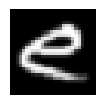

Predicted value: e Actual value: e 


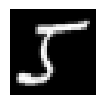

Predicted value: 5 Actual value: J Wrong


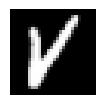

Predicted value: V Actual value: V 


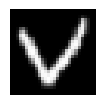

Predicted value: V Actual value: V 


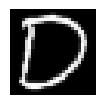

Predicted value: D Actual value: D 


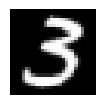

Predicted value: 3 Actual value: 3 


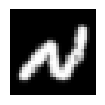

Predicted value: N Actual value: N 


In [24]:
# Plot random predictions
plotRandomPredictions(regSvmPredictions, X_test, y_test, 7)

### Random Forest

In [ ]:
# Random forest
from sklearn.ensemble import RandomForestClassifier

# Define model
rfModel = RandomForestClassifier(random_state = 42)

# Training
rfModel.fit(X_train, y_train)

# Saving the model
joblib.dump(rfModel, '/Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts/rfModel2.joblib')

In [11]:
rfModel_loaded = joblib.load('/Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts/rfModel2.joblib')

In [11]:
# Predictions
rfPredictions = rfModel_loaded.predict(X_test)

# Accuracy Score
print('RF Accuracy Score:', accuracy_score(y_test, rfPredictions))

# Classification Report
print('RF Classification Report:\n', classification_report(y_test, rfPredictions))

RF Accuracy Score: 0.8060283687943263
RF Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.66      0.61       457
           1       0.52      0.66      0.58       472
           2       0.86      0.80      0.83       479
           3       0.90      0.91      0.91       515
           4       0.84      0.87      0.85       460
           5       0.83      0.81      0.82       473
           6       0.83      0.85      0.84       484
           7       0.90      0.95      0.92       447
           8       0.77      0.78      0.78       496
           9       0.63      0.79      0.70       480
          10       0.77      0.88      0.82       494
          11       0.82      0.81      0.82       465
          12       0.90      0.89      0.89       469
          13       0.85      0.84      0.84       500
          14       0.90      0.88      0.89       465
          15       0.66      0.54      0.59       467
          16    

In [11]:
# RF cross-validation
rfCVScore = cross_val_score(rfModel, X_train, y_train, cv = 5, scoring = 'accuracy').mean()

print('RF cross-validation score:', rfCVScore)

RF cross-validation score: 0.8019281914893618


In [12]:
# Save cross-validation score
joblib.dump(rfCVScore, '/Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts/rfCVScore.joblib')

['/Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts/rfCVScore.joblib']

In [12]:
# RF Regularization
rfPrams = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 30, 50]
}

gridRf = GridSearchCV(rfModel_loaded, rfPrams, cv = 5, scoring = 'accuracy')

In [13]:
# Training the model
gridRf.fit(X_train, y_train)

# Saving the model
joblib.dump(gridRf, '/Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts/gridRf.joblib')

['/Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts/gridRf.joblib']

In [14]:
print('Best score:', gridRf.best_score_)
print('Best parameters:', gridRf.best_params_)
print('Best estimator:', gridRf.best_estimator_)

Best score: 0.8052859042553193
Best parameters: {'max_depth': None, 'n_estimators': 150}
Best estimator: RandomForestClassifier(n_estimators=150, random_state=42)


In [16]:
print(rfModel_loaded.max_features)
print(rfModel_loaded.min_samples_leaf)
print(rfModel_loaded.max_features)

sqrt
1
sqrt


In [17]:
# RF Regularization #2
rfPrams2 = {
    'n_estimators': [150, 250, 350]
}

gridRf2 = GridSearchCV(rfModel_loaded, rfPrams, cv = 5, scoring = 'accuracy')

# Training the model
gridRf2.fit(X_train, y_train)

# Saving the model
joblib.dump(gridRf2, '/Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts/gridRf2.joblib')

['/Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts/gridRf2.joblib']

In [18]:
print('Best score:', gridRf2.best_score_)
print('Best parameters:', gridRf2.best_params_)
print('Best estimator:', gridRf2.best_estimator_)

Best score: 0.8052859042553193
Best parameters: {'max_depth': None, 'n_estimators': 150}
Best estimator: RandomForestClassifier(n_estimators=150, random_state=42)


In [20]:
from sklearn.ensemble import RandomForestClassifier

# Regularized model
regRf = RandomForestClassifier(n_estimators = 150, random_state = 42)

regRf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=150, random_state=42)

In [21]:
# Predictions
regRfPredictions = regRf.predict(X_test)

In [22]:
# Accuracy after regularization
print('Regularized RF accuracy score:', accuracy_score(y_test, regRfPredictions))

Regularized RF accuracy score: 0.8094414893617021


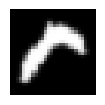

Predicted value: r Actual value: r 


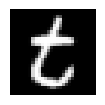

Predicted value: t Actual value: t 


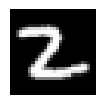

Predicted value: Z Actual value: Z 


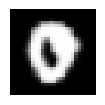

Predicted value: O Actual value: 0 Wrong


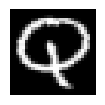

Predicted value: Q Actual value: Q 


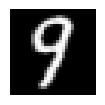

Predicted value: 9 Actual value: 9 


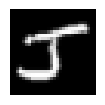

Predicted value: J Actual value: J 


In [28]:
# Plot random predictions
plotRandomPredictions(regRfPredictions, X_test, y_test, 7)

### MLP

In [12]:
# Transform labels
from keras.utils import to_categorical

numberOfClasses = 47

y_train = to_categorical(y_train, numberOfClasses)
y_test = to_categorical(y_test, numberOfClasses)

In [11]:
# keras version
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import save_model, load_model
import cv2

In [12]:
mlpModel = Sequential()

mlpModel.add(Dense(512, activation = 'relu', input_shape = (784,)))
mlpModel.add(Dense(256, activation = 'relu'))

# mlpModel.add(Dropout(0.2))

mlpModel.add(Dense(256, activation = 'relu'))
# mlpModel.add(Dropout(0.2))

mlpModel.add(Dense(256, activation = 'relu'))
# mlpModel.add(Dropout(0.2))

mlpModel.add(Dense(numberOfClasses, activation = 'softmax'))

In [13]:
mlpModel.compile(optimizer = Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [14]:
# Save best points when the model is improving
mlpModel_best_points_path = '/Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts/mlpModel_Best_points.h5'
MCP = ModelCheckpoint(mlpModel_best_points_path, verbose = 1, save_best_only = True, monitor = 'val_accuracy', mode = 'max')

# Early stop when the model stops improving
ES = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, verbose = 0, restore_best_weights = True, patience = 3, mode = 'max')

# Reduce the learning rate when the model stops improving, val_loss specifically
RLP = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, factor = 0.2, min_lr = 0.0001)

In [15]:
# Model training
mlpModel_history = mlpModel.fit(X_train, y_train, epochs = 20, validation_data = (X_test, y_test), callbacks = [MCP, ES, RLP])

Epoch 1/20
2818/2820 [============================>.] - ETA: 0s - loss: 0.8923 - accuracy: 0.7207
Epoch 1: val_accuracy improved from -inf to 0.78488, saving model to /Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts\mlpModel_Best_points.h5
2820/2820 [==============================] - 32s 10ms/step - loss: 0.8921 - accuracy: 0.7207 - val_loss: 0.6455 - val_accuracy: 0.7849 - lr: 0.0010
Epoch 2/20
2818/2820 [============================>.] - ETA: 0s - loss: 0.5543 - accuracy: 0.8116
Epoch 2: val_accuracy improved from 0.78488 to 0.81560, saving model to /Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts\mlpModel_Best_points.h5
2820/2820 [==============================] - 26s 9ms/step - loss: 0.5543 - accuracy: 0.8116 - val_loss: 0.5492 - val_accuracy: 0.8156 - lr: 0.0010
Epoch 3/20
2814/2820 [============================>.] - ETA: 0s - loss: 0.4768 - accuracy: 0.8337
Epoch 3: val_accuracy improved from 0.81560 to 0.81986, saving model to /Users/pc/PythonDevEnv/dsenv/PFE/model/sav

In [16]:
score = mlpModel.evaluate(X_test, y_test, verbose = 2)
print("Test score:", score[0])
print('Test accuracy:', score[1])

705/705 - 4s - loss: 0.6348 - accuracy: 0.8628 - 4s/epoch - 5ms/step
Test score: 0.6347954273223877
Test accuracy: 0.8628102540969849


In [17]:
# Saving the model
save_model(mlpModel, '/Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts/mlpModel_attempt1.h5')

In [11]:
# Load the model
mlpModel_loaded = load_model('/Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts/mlpModel_attempt1.h5')

In [21]:
# Regularization using L2 Regularization and dropout layers
from keras import regularizers

# Function to create an MLP model
def createMlpModel(hiddenLayers = (256,), dropoutRate = 0.0, alpha = 0.0):
    model = Sequential()
    model.add(Dense(hiddenLayers[0], activation = 'relu', input_shape = (784,)))
    model.add(Dropout(dropoutRate))
    
    for units in hiddenLayers[1:]:
        model.add(Dense(units, activation = 'relu', kernel_regularizer = regularizers.l2(alpha)))
        model.add(Dropout(dropoutRate))
        
    model.add(Dense(numberOfClasses, activation = 'softmax'))
    
    model.compile(optimizer = Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [22]:
# Create the Keras classifier wrapper, to make the function compatible with scikit-learn's GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

kerasClassifier = KerasClassifier(build_fn = createMlpModel, verbose = 0)

# Define the parameter grid
mlpParams = {
    'hiddenLayers': [(512, 256, 256, 256), (512, 256, 256, 128), (256, 128, 128)],
    'dropoutRate': [0.0, 0.2, 0.5],
    'alpha': [0.0, 0.01, 0.1]
}

# Perform grid search
gridMlp = GridSearchCV(kerasClassifier, mlpParams, cv = 5)

C:\Users\pc\AppData\Local\Temp\ipykernel_5500\1687717899.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  kerasClassifier = KerasClassifier(build_fn = createMlpModel, verbose = 0)


In [23]:
gridMlp.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x00000154C3A549A0>,
             param_grid={'alpha': [0.0, 0.01, 0.1],
                         'dropoutRate': [0.0, 0.2, 0.5],
                         'hiddenLayers': [(512, 256, 256, 256),
                                          (512, 256, 256, 128),
                                          (256, 128, 128)]})

In [24]:
print('Best score:', gridMlp.best_score_)
print('Best parameters:', gridMlp.best_params_)
print('Best estimator:', gridMlp.best_estimator_)

Best score: 0.7789782762527466
Best parameters: {'alpha': 0.0, 'dropoutRate': 0.0, 'hiddenLayers': (512, 256, 256, 256)}
Best estimator: <keras.wrappers.scikit_learn.KerasClassifier object at 0x00000154C4D13250>


In [29]:
# Saving the model
regMlp = gridMlp.best_estimator_.model

save_model(regMlp, '/Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts/regMlp1.h5')

In [37]:
regMlpModel_best_points_path = '/Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts/regMlpModel_Best_points.h5'
regMCP = ModelCheckpoint(regMlpModel_best_points_path, verbose = 1, save_best_only = True, monitor = 'val_accuracy', mode = 'max')
regES = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, verbose = 0, restore_best_weights = True, patience = 3, mode = 'max')
regRLP = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, factor = 0.2, min_lr = 0.0001)

In [38]:
regMlp_history = regMlp.fit(X_train, y_train, epochs = 20, validation_data = (X_test, y_test), callbacks = [regMCP, regES, regRLP])

Epoch 1/20
2811/2820 [============================>.] - ETA: 0s - loss: 0.5486 - accuracy: 0.8127
Epoch 1: val_accuracy improved from -inf to 0.82039, saving model to /Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts\regMlpModel_Best_points.h5
2820/2820 [==============================] - 18s 6ms/step - loss: 0.5482 - accuracy: 0.8128 - val_loss: 0.5370 - val_accuracy: 0.8204 - lr: 0.0010
Epoch 2/20
2820/2820 [==============================] - ETA: 0s - loss: 0.4726 - accuracy: 0.8350
Epoch 2: val_accuracy did not improve from 0.82039
2820/2820 [==============================] - 17s 6ms/step - loss: 0.4726 - accuracy: 0.8350 - val_loss: 0.5374 - val_accuracy: 0.8151 - lr: 0.0010
Epoch 3/20
2818/2820 [============================>.] - ETA: 0s - loss: 0.4230 - accuracy: 0.8499
Epoch 3: val_accuracy improved from 0.82039 to 0.82420, saving model to /Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts\regMlpModel_Best_points.h5
2820/2820 [==============================] - 17s 6ms/step 

Text(0, 0.5, 'Accuracy')

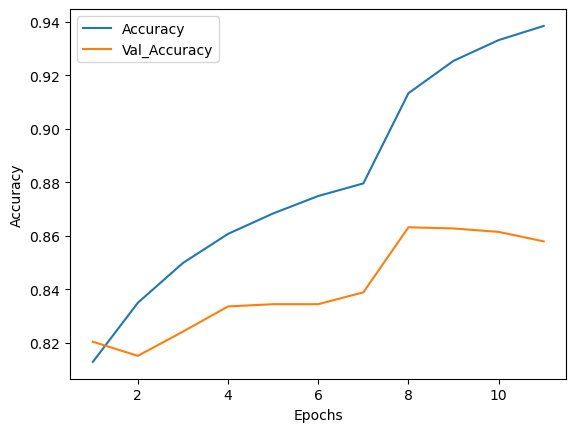

In [73]:
import seaborn as sns
length = len(regMlp_history.history['accuracy'])

plt.figsize = (10,10)
sns.lineplot(x = range(1, 1 + length), y = regMlp_history.history['accuracy'], label = 'Accuracy')
sns.lineplot(x = range(1, 1 + length), y = regMlp_history.history['val_accuracy'], label = 'Val_Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [39]:
score = regMlp.evaluate(X_test, y_test, verbose = 2)
print("Test score:", score[0])
print('Test accuracy:', score[1])

705/705 - 2s - loss: 0.4730 - accuracy: 0.8632 - 2s/epoch - 3ms/step
Test score: 0.47301483154296875
Test accuracy: 0.8632092475891113


In [40]:
# Saving trained regularized model
save_model(regMlp, '/Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts/regMlp2.h5')

In [41]:
# Predictions
regMlpPredictions = regMlp.predict(X_test)

705/705 [==============================] - 3s 4ms/step


In [71]:
def plotRandomPredictionsForMLP(predictions, test_X, test_y, n_samples = 5):
    predSamples = np.random.choice(len(predictions), size = n_samples).astype(int)

    for j in predSamples:
        predicted = np.argmax(predictions[j])
        actual = np.argmax(test_y[j])

        image = test_X[j]
        plt.subplot(3, 5, 2)
        plt.imshow(image.reshape(28, 28), cmap = 'gray')
        plt.axis('off')
        plt.show()

        print("Predicted:", labelsDict[predicted], "Actual:", labelsDict[actual], '' if predicted == actual else 'Wrong')

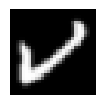

Predicted: V Actual: V 


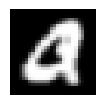

Predicted: a Actual: a 


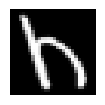

Predicted: b Actual: h Wrong


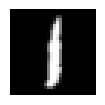

Predicted: 1 Actual: 1 


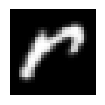

Predicted: r Actual: r 


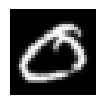

Predicted: O Actual: 0 Wrong


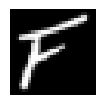

Predicted: F Actual: F 


In [72]:
plotRandomPredictionsForMLP(regMlpPredictions, X_test, y_test, 7)

## Train the model with Augmented data

In [18]:
mergedData = pd.read_csv('/Users/pc/PythonDevEnv/dsenv/PFE/dataset/merged_emnist_balanced_dataset.csv')

In [19]:
print('Data shape:', mergedData.shape)

Data shape: (131600, 785)


In [20]:
XFull = mergedData.iloc[:, 1:].values
yFull = mergedData.iloc[:, 0].values

print('Train shape:', XFull.shape)
print('Test shape:', yFull.shape)

Train shape: (131600, 784)
Test shape: (131600,)


In [21]:
XFull = XFull / 255

In [22]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(XFull, yFull, test_size = 0.2, random_state = 42)

In [23]:
print('X_train shape:', X_train2.shape, 'y_train shape:', y_train2.shape)
print('X_test shape:', X_test2.shape, 'y_test shape:', y_test2.shape)

X_train shape: (105280, 784) y_train shape: (105280,)
X_test shape: (26320, 784) y_test shape: (26320,)


In [24]:
y_train2 = to_categorical(y_train2, numberOfClasses)
y_test2 = to_categorical(y_test2, numberOfClasses)

In [26]:
regMlp2 = load_model('/Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts/regMlp1.h5')

In [27]:
regMlpModel_best_points_path2 = '/Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts/regMlpModel_Best_points_with_fullData.h5'
regMCP2 = ModelCheckpoint(regMlpModel_best_points_path2, verbose = 1, save_best_only = True, monitor = 'val_accuracy', mode = 'max')
regES2 = EarlyStopping(monitor = 'val_accuracy', min_delta = 0, verbose = 0, restore_best_weights = True, patience = 3, mode = 'max')
regRLP2 = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, factor = 0.2, min_lr = 0.0001)

In [28]:
regMlp_history2 = regMlp2.fit(X_train2, y_train2, epochs = 30, validation_data = (X_test2, y_test2), callbacks = [regMCP2, regES2, regRLP2])

Epoch 1/30
3290/3290 [==============================] - ETA: 0s - loss: 0.7498 - accuracy: 0.7591
Epoch 1: val_accuracy improved from -inf to 0.80395, saving model to /Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts\regMlpModel_Best_points_with_fullData.h5
3290/3290 [==============================] - 30s 8ms/step - loss: 0.7498 - accuracy: 0.7591 - val_loss: 0.5797 - val_accuracy: 0.8040 - lr: 0.0010
Epoch 2/30
3284/3290 [============================>.] - ETA: 0s - loss: 0.5096 - accuracy: 0.8250
Epoch 2: val_accuracy improved from 0.80395 to 0.81512, saving model to /Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts\regMlpModel_Best_points_with_fullData.h5
3290/3290 [==============================] - 19s 6ms/step - loss: 0.5096 - accuracy: 0.8251 - val_loss: 0.5666 - val_accuracy: 0.8151 - lr: 0.0010
Epoch 3/30
3285/3290 [============================>.] - ETA: 0s - loss: 0.4457 - accuracy: 0.8432
Epoch 3: val_accuracy improved from 0.81512 to 0.82382, saving model to /Users/pc

### Accuracy didn't change at all !!!

## UI

In [13]:
# MLP
regMlpModel_loaded = load_model('/Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts/regMlp2.h5')

# SVM
# svmModel_loaded2 = joblib.load('/Users/pc/PythonDevEnv/dsenv/PFE/model/savedArtifacts/svmModel2.joblib')

1/1 [==============================] - 0s 86ms/step
Label entry No. 0: 0


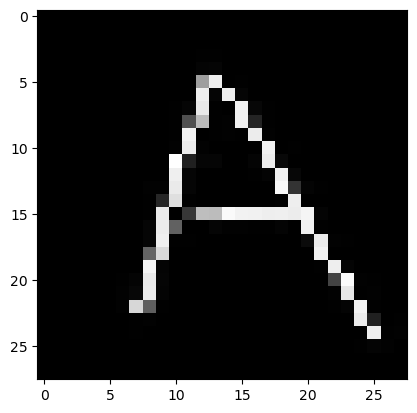

In [15]:
# Load the image
image = cv2.imread('../testImages/test7.jpg')

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Check if the background is black or white
average_color = np.mean(gray)
if average_color > 127:  # If average color is above threshold (e.g., 127), consider it as white background
    # Invert the image
    inverted = cv2.bitwise_not(gray)
    processed_image = inverted
else:
    processed_image = gray

# Resize the image to 28x28 pixels
resized = cv2.resize(processed_image, (28, 28), interpolation = cv2.INTER_CUBIC)

# Reshape the image to match the input shape of the model
image_array = resized.reshape((1, 784))

# Transform the image array to grayscale values between 0 and 255
image_array = image_array.astype('int64') / 255

# Prediction using MLP
y_pred2 = regMlpModel_loaded.predict(image_array)
pred2 = np.argmax(y_pred2)

# Prediction using SVM
# y_pred3 = svmModel_loaded2.predict(image_array)
# pred3 = np.argmax(y_pred3)

print(f"Label entry No. {pred2}:", labelsDict[pred2])

# Display the image
plt.imshow(resized, cmap = plt.cm.gray)
plt.show()

In [25]:
def processImage(image):
    # image = cv2.imread(image)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    average_color = np.mean(gray)
    if average_color > 127:
        inverted = cv2.bitwise_not(gray)
        processed_image = inverted
    else:
        processed_image = gray

    resized = cv2.resize(processed_image, (28, 28), interpolation=cv2.INTER_CUBIC)

    image_array = resized.reshape((1, 784))

    image_array = image_array.astype('int64') / 255
    
    return image_array, resized

1/1 [==============================] - 0s 65ms/step
Predicted: A


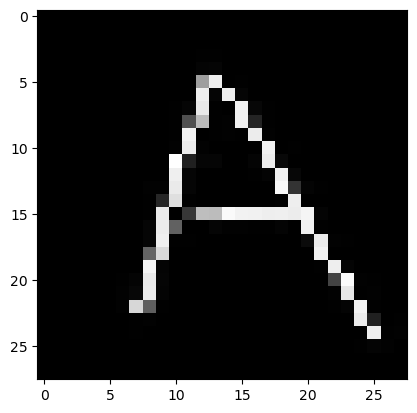

In [24]:
# using MLP
testImage, resizedImage = processImage('../testImages/test7.jpg')
prediction = np.argmax(regMlpModel_loaded.predict(testImage))

print(f"Predicted:", labelsDict[prediction])

plt.imshow(resizedImage, cmap = 'gray')
plt.show()

In [16]:
import gradio as gr

def modelFunction(imageInput):
    testImage, _ = processImage(imageInput)
    prediction = np.argmax(regMlpModel_loaded.predict(testImage))
    output = labelsDict[prediction]
    
    return f'Symbol is: {output}'

In [17]:
interface = gr.Interface(fn = modelFunction, inputs = "image", outputs = "text")
interface.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [18]:
def modelFunction_sketch(sketchInput):
    # Convert sketch to image
    sketch = sketchInput.copy()
    sketch = cv2.cvtColor(sketch, cv2.COLOR_GRAY2BGR)

    # Preprocess image
    testImage, _ = processImage(sketch)
    prediction = np.argmax(regMlpModel_loaded.predict(testImage))
    output = labelsDict[prediction]

    return f'Symbol is: {output}'

In [20]:
iface = gr.Interface(fn = modelFunction_sketch, inputs = "sketchpad", outputs = "text")
iface.launch()

Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 72ms/step
